In [1]:
import os, tqdm
import numpy as np
from cartoframes.viz import *
import pandas as pd
import geopandas as gpd

Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [2]:
streetmap = {
    'style': 'mapbox://styles/mapbox/streets-v9',
    'token': 'pk.eyJ1IjoiaHNtNjkxMSIsImEiOiJjazl0and6aDUwOWF2M2RvemdrYjllczV3In0.qGmaAF6v-1LAF9C-dnMLBg'
}
mybasemap = {
    #'style': 'mapbox://styles/mapbox/streets-v9',
    'style': 'mapbox://styles/mapbox/satellite-v9',
    'token': 'pk.eyJ1IjoiaHNtNjkxMSIsImEiOiJjazl0and6aDUwOWF2M2RvemdrYjllczV3In0.qGmaAF6v-1LAF9C-dnMLBg'
}

In [3]:
from sklearn.metrics import r2_score
import numpy as np

# metric
def metric(pred, label):
    assert label.shape == pred.shape
    
    with np.errstate(divide = 'ignore', invalid = 'ignore'):
        mask = np.not_equal(label, 0)
        mask = mask.astype(np.float32)
        mask /= np.mean(mask)
        male = np.abs(np.subtract(np.log(pred), np.log(label))).astype(np.float32)
        male = np.nan_to_num(male * mask)
        male = np.mean(male)
        mae = np.abs(np.subtract(pred, label)).astype(np.float32)
        rmse = np.square(mae)
        mape = np.divide(mae, label)
        mae = np.nan_to_num(mae * mask)
        mae = np.mean(mae)
        rmse = np.nan_to_num(rmse * mask)
        rmse = np.sqrt(np.mean(rmse))
        mape = np.nan_to_num(mape * mask)
        mape = np.median(mape) # np.mean(mape) -- author leverages median
    return male, rmse, mape



In [4]:
for dname in ['fc', 'kc', 'poa', 'sp']:

    print(dname)
    data = np.load(f'{dname}/data.npz')

    dict1 = {'lat':data['X_train'][:,0], 'lng': data['X_train'][:,1], 'price': data['y_train']}
    dict2 = {'lat':data['X_test'][:,0], 'lng': data['X_test'][:,1], 'price': data['y_test']}
    attr_names = []
    for a in range(2, data['X_train'].shape[1]):
        dict1.update({f'attr{a-2}': data['X_train'][:, a]})
        dict2.update({f'attr{a-2}': data['X_test'][:, a]})
        attr_names.append(f'attr{a-2}')
    df1 = pd.DataFrame(dict1)
    df2 = pd.DataFrame(dict2)
    df = pd.concat([df1, df2])

    train_gdf = gpd.GeoDataFrame(df1.copy(), geometry=gpd.points_from_xy(x=df1.lng, y=df1.lat))
    train_gdf.crs = 'EPSG:4326'
    test_gdf = gpd.GeoDataFrame(df2.copy(), geometry=gpd.points_from_xy(x=df2.lng, y=df2.lat))
    test_gdf.crs = 'EPSG:4326'
    house_gdf = gpd.GeoDataFrame(df.copy(), geometry=gpd.points_from_xy(x=df.lng, y=df.lat))
    house_gdf.crs = 'EPSG:4326'
    #print(np.exp(df['price'].values).mean())
    gdf = house_gdf
    for attr in attr_names:
        print(attr, gdf[attr].nunique())
        if gdf[attr].nunique() < 30:
            gdf[attr] = gdf[attr].astype(str)
    gdfcpy = gdf.copy()
    
    ####################
    
    X_all = np.concatenate((data['X_train'], data['X_test']), 0)
    X_norm = (X_all - X_all.mean(0)) / X_all.std(0)

    newdata = dict() 
    newdata['X_train'] = X_norm[:len(train_gdf), :]
    newdata['y_train'] = data['y_train']
    newdata['X_test'] = X_norm[len(train_gdf):, :]
    newdata['y_test'] = data['y_test']
    newdata['idx_eucli'] = data['idx_eucli']
    newdata['idx_geo'] = data['idx_geo']
    newdata['dist_eucli'] = data['dist_eucli']
    newdata['dist_geo'] = data['dist_geo']
    np.savez(f'{dname}/data_normalized.npz', **newdata)

    #vectors = np.load(f'{dname}/road2vec_n2v_32_nodes.npy')
    np.save(f'{dname}/feat_norm.npy', X_norm)
    

fc
attr0 6447
attr1 18
attr2 11
attr3 6447
attr4 16372
attr5 79
attr6 3230
attr7 8
attr8 6
kc
attr0 13
attr1 30
attr2 1038
attr3 9782
attr4 6
attr5 2
attr6 5
attr7 5
attr8 12
attr9 946
attr10 306
attr11 116
attr12 70
attr13 70
attr14 777
attr15 8689
poa
attr0 9
attr1 2644
attr2 10
attr3 2
attr4 2
sp
attr0 10
attr1 467
attr2 10
attr3 2
attr4 2


fc
fc (0.11249575, 26926.787, 0.07058302914474623)


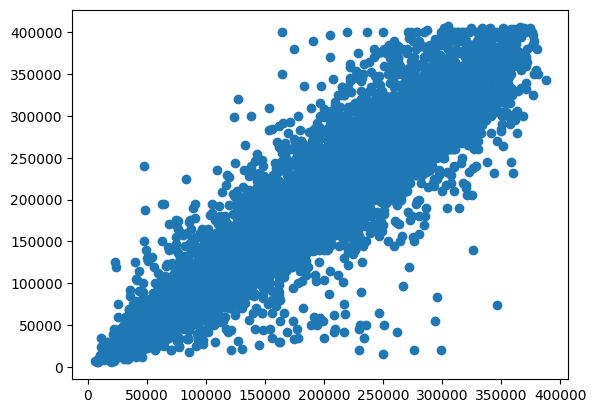

kc
kc (0.124153554, 137489.52, 0.08529448225400957)


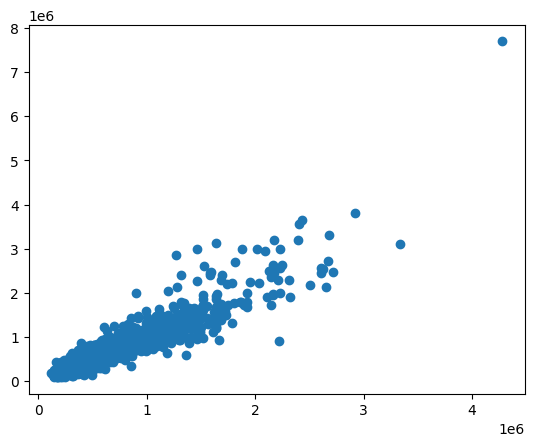

poa
poa (0.16093375, 101328.72, 0.115505553450197)


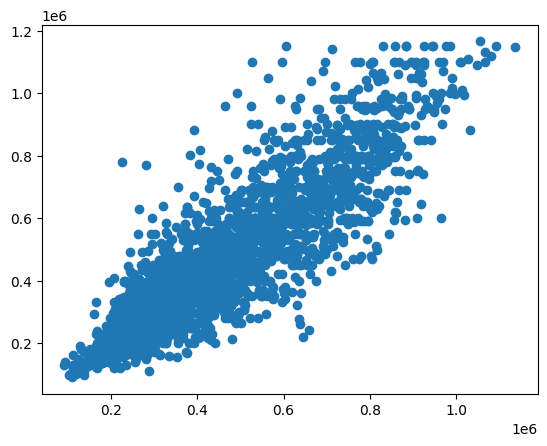

sp
sp (0.14064622, 159602.6, 0.10191185210451559)


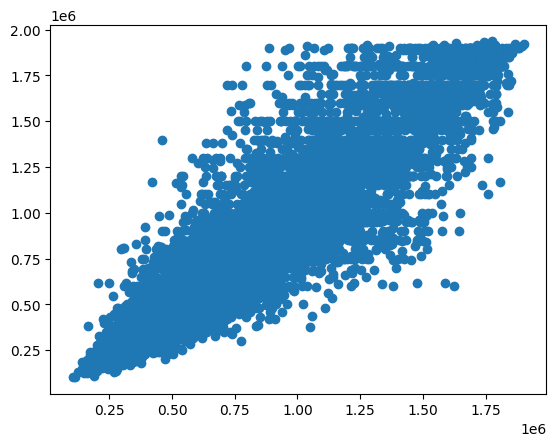

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


for dname in ['fc', 'kc', 'poa', 'sp']:

    print(dname)
    newdata = np.load(f'{dname}/data_normalized.npz')
    
    
    # Load the Boston Housing dataset as an example

    X_train = newdata['X_train']
    y_train = newdata['y_train']
    X_test = newdata['X_test']
    y_test = newdata['y_test']

    # Create a Random Forest Regressor with 100 trees
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

    # Fit the model on the training data
    rf_regressor.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = rf_regressor.predict(X_test)

    y_pred = np.exp(y_pred)
    y_label = np.exp(y_test)

    # Calculate the Mean Squared Error (MSE) of the predictions
    print(dname, metric(y_pred, y_label))
    import matplotlib.pyplot as plt
    plt.scatter(y_pred, y_label)
    plt.show()